# Length correction of AlpacaEval

This notebook is about trying to correct for the length bias in AlpacaEval. 

In [1]:
cd ..

/Users/yanndubois/Desktop/GitHub/alpaca_eval


In [2]:
from dotenv import load_dotenv
load_dotenv(".env")

True

## Desiderata?

Here are the things that I think we should be considering when deciding
1. **(D1) Avoid length gameability** This is the real goal we are trying to solve with length correction. Note that this is related but different from minimizing length bias. The reason why we care about gameability instead of bias, is that humans also prefer longer outputs.
2. **(D2) Keep high correlation with humans** see below I think we should be considering Spearman correlation with Arena.
3. **(D3) Similar length bias as humans**: human are typically length biased, we would like
4. **Simplicity**: the model length correction should be simple enough for people to understand what is happening and what are limitations of the length corrections. Let's not hide the limitations (and potential gameability) behind complexity.
5. **Similar interpretation as win-rate**: given that we'll use for the default AE metric, we would like the interpretation of the result to be as similar as  possible as the non-bias corrected ones given that people are used to those. I.e. preference for having 50% for the baseline, the range being between 0-100, ...

In addition to the aforementioned desired properties, we have a hard constraint that there should be **no reevaluation needed**. I.e., the new metric should be a function of what we currently have to ensure that we can port the leaderboard.

Now let's check how to decide whether a method is better or worse, i.e., what metrics to consider for the rest of the notebook.

## Metrics?
Here are the metrics I think we should be considering, one for each of the three desiderata.

- **(D1) Small relative variance when prompting for verbosity/conciseness.** One heuristic to avoid gameability is to ensure that the win-rate for a model is close to the win-rate of the same model prompted for verbosity. To test that we will use a few models and prompt them (1) normally, (2) to "give as much detail as possible", (3) to "be as concise as possible while still providing all the necessary information to answer the question". Then we will look at the variance between those three, which ideally shouldn't be too large. We will use GPT4-turbo, Claude 2, GPT3-turbo, GPT4, Mixtral. In particular, we will consider the relative standard deviation. Standard deviation, simply because it's easier to interpret. Relative in the sense that we (1) normalize by the non-gamed win rate, and (2) we normalize by the standard deviation of different models, i.e., squishing the range of the metric shouldn't solve the gameability issue.

- **(D2) High Spearman correlation with Chatbot Arena Leaderboard.** This is the most important, and see below why I think we should be using Chatbot Arena Leaderboard here. The question then becomes which correlations. Given that ELO and win rate are very different metrics (e.g. one is bounded and not the other) there's no reason to hope that linear correlation holds, so we shouldn't use Pearson. More importantly, we only care about relative values with a benchmark like AlpacaEval (the usecase being model selection) so non-parametric correlation is better suited. Note that the choice of Spearman vs Kendall doesn't matter much here, we will use Spearman because it's on "the same scale" as Pearson correlation which people are more used to (e.g. Dendall is much smaller which always surprises people because they are not used to interpreting it). Also note that when using non-parametric correlations it's extremely important to fix the number of points you are comparing, otherwise more always looks better. 
  
- **(D3) Same Spearman correlation AE-Length as Arena-Length.** To track the length bias of humans we can see how correlated the Arena leaderboard is with a leaderboard that simply ranks outputs by their lengths. Again we use Spearman correlations.

## Human Data?

There are two sources of human data that we use for evaluation of the method:
- **AlpacaFarm cross-annotation data**: this is 650 samples cross-annotated by 4 humans (2.5K annotations) on the AlpacaEval instructions. The benefits and downsides are that:
    - (+) we have *cross-annotations* so we can remove noise in the process
    - (+) the *humans were paid* to do the best possible evaluation job and checked for their quality => less noise
    - (+) the instructions are a *subset of the AlpacaEval instructions* => instructions are in distribution
    - (+) the evaluation is performed in the same way as AlpacaEval (win rate) 
    - (-) the models evaluated are *old* => outputs are out of distribution (especially length)
    - (-) humans were paid => ~optimizing for money => likely more biased (e.g. to perform the task quickly)
    - (-) instructions are less realistic
    - (-) fewer models to compute correlations with

- **Chatbot Arena Leaderboard** this is >250K pairwise comparisons evaluated by humans on instructions that they came up with. There are more than 50 models and currently (7th feb 2024) 24 of those models that are evaluated in AlpacaEval2.0. Shoutout to [Balázs Galambosi](https://github.com/gblazex) who's been adding models from the Arena to AlpacaEval. The benefits and downsides are essentially the opposite as above, here are some to highlight
    - (+) in the wild human interactions => more realistic instructions and potentially less bias for preferences
    - (+) more recent models => in distribution ouputs (esepecially length)
    - (+) more models to compute the correlation with & more data
    - (-) instructions and the metric (Elo) is different => more out of distribution

Overall **correlations with Arena leaderboard are better for length bias** because:
1. Outputs of new models are much longer than from the old models => AlpacaFarm human data is not great for 
2. I think that optimizing for speed & money likely increases the bias toward length

So I don't think AlpacaFarm human data is great for studying length bias. I will still keep track of it but we should focus on correlation with Arena.





## Setting up 

In [3]:
from alpaca_eval import utils, metrics, annotators, constants, analyze, plotting, main
import pandas as pd
from IPython.display import display
import scipy.stats
import numpy as np
BASELINE = "gpt4_1106_preview"

/Users/yanndubois/opt/anaconda3/envs/alpaca_eval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
lb = pd.read_csv("src/alpaca_eval/leaderboards/data_AlpacaEval_2/weighted_alpaca_eval_gpt4_turbo_leaderboard.csv", index_col=0)

def make_lb_arena(lb):
    lb_arena = lb.loc[list(constants.CHATBOT_ARENA_LEADERBOARD.keys()),:]
    lb_arena["ELO"] = constants.CHATBOT_ARENA_LEADERBOARD.values()
    return lb_arena

lb_arena = make_lb_arena(lb)
print(f"We are comparing to {len(lb_arena)} Arena models")

We are comparing to 33 Arena models


In [5]:
game_process_v = lambda s : s.replace("_verbose","")
game_process_c = lambda s : s.replace("_concise","")
gamed_models = [i for i in lb.index
               if (i + "_verbose") in lb.index and (i + "_concise") in lb.index]
diff_models = [i for i in lb.index
               if "_verbose" not in i and i + "_concise" not in i]
lb["gamed_verbose_only"] = [game_process_v(i) if game_process_v(i) in gamed_models else None for i in lb.index]
lb["gamed_concise_only"] = [game_process_c(i) if game_process_c(i) in gamed_models else None for i in lb.index]

Here are the models that we gamed (i.e. prompted for verbosity/conciseness)

In [6]:
gamed_models

['gpt4_1106_preview',
 'Mixtral-8x7B-Instruct-v0.1',
 'gpt4_0613',
 'claude-2.1',
 'gpt-3.5-turbo-1106',
 'alpaca-7b']

In [7]:

def report(lb, metric, is_detailed=False, n_toshow=10, is_return_metrics=False):
    lb_arena = make_lb_arena(lb)

    if not is_return_metrics:
        print(f"# Report for **{metric}**")

        print()
        print("## Gameability (lower is better)")

    df_gamed_v = lb.groupby("gamed_verbose_only")[["avg_length", metric]].agg(["mean","std"]) 
    df_gamed_c = lb.groupby("gamed_concise_only")[["avg_length", metric]].agg(["mean","std"]) 
    # relative in the sense that models with larger metric shouldn't be considered as having larger vairance
    df_gamed_v[(metric, 'rel_std')] = df_gamed_v[metric]["std"] /  df_gamed_v[metric]["mean"]
    df_gamed_c[(metric, 'rel_std')] = df_gamed_c[metric]["std"] /  df_gamed_c[metric]["mean"] 
    # renormalize to avoid removing gameability by shrinking the scale of the metric
    winrate_std_across_models = lb[lb.index.isin(diff_models)]["win_rate"].std()
    metric_std_across_models = lb[lb.index.isin(diff_models)][metric].std()
    metric_weight = winrate_std_across_models / metric_std_across_models 
    
    if is_detailed:
        print(f"metric_weight: {metric_weight:.3f}")
        display(df_gamed_v)
        display(df_gamed_c)

    verbosity_gameability = df_gamed_v[metric]['rel_std'].mean() * metric_weight * 100
    conciseness_gameability = df_gamed_c[metric]['rel_std'].mean() * metric_weight * 100
    
    if not is_return_metrics:
        print(f"Verbosity gameability (relative std metric): {verbosity_gameability:.1f}%")
        print(f"Conciseness gameability (relative std metric): {conciseness_gameability:.1f}%")

        print()
        print("## Correlation with Arena (higher is better)")

    corr_arena = print_correlations(lb_arena[metric], lb_arena["ELO"], is_return_metrics=is_return_metrics)

    if not is_return_metrics:
        print()
        arena_corr = print_correlations(lb_arena["ELO"],
                                       lb_arena["avg_length"],
                                        "Arena vs Length", 
                                        is_return_metrics=True)
        print(f"## Correlation with length (closer to spearman={arena_corr['spearman']:.2f}, kendall={arena_corr['kendall']:.2f} is better)")
    
    corr_len = print_correlations(lb_arena[metric], lb_arena["avg_length"], is_return_metrics=is_return_metrics)

    if not is_return_metrics:
        print()
        print(f"## Top {n_toshow} models")
    
        display(lb[metric].sort_values(ascending=False)[:n_toshow])
    
        print()
        print(f"## Bottom {n_toshow} models")
    
        display(lb[metric].sort_values(ascending=False)[-n_toshow:])

    if is_return_metrics:
        return dict(verbosity_gameability=verbosity_gameability, 
                    conciseness_gameability=conciseness_gameability,
                   corr_arena=corr_arena["spearman"],
                    corr_len=corr_len["spearman"])

    

In [8]:

def print_correlations(arr1, arr2, txt="", is_return_metrics=False):
    if isinstance(arr1, pd.DataFrame):
        arr1 = list(arr1.index)
    if isinstance(arr2, pd.DataFrame):
        arr2 = list(arr2.index)
    s = scipy.stats.spearmanr(arr1, arr2).statistic
    t = scipy.stats.kendalltau(arr1, arr2).statistic
    
    if is_return_metrics:
        return dict(spearman=s, kendall=t)
    else:
        if txt != "":
            txt = txt + "\n"
        print(f"{txt}Spearman Corr: {s:.3f}\nKendall Corr: {t:.3f}")

Here are the correlations between Arena and length that we should try to be close to. 

In [9]:
print_correlations(lb_arena["ELO"],
                   lb_arena["avg_length"],
                  "Arena vs Length")

Arena vs Length
Spearman Corr: 0.235
Kendall Corr: 0.163


## Raw win rate

- **What**: compute the expected number of times that the model is better than the baseline. This is the default in AE.
- **Benefits**: simple 
- **Downside**: length bias

In [10]:
report(lb, "win_rate", is_detailed=False)

# Report for **win_rate**

## Gameability (lower is better)
Verbosity gameability (relative std metric): 21.3%
Conciseness gameability (relative std metric): 29.8%

## Correlation with Arena (higher is better)
Spearman Corr: 0.925
Kendall Corr: 0.796

## Correlation with length (closer to spearman=0.23, kendall=0.16 is better)
Spearman Corr: 0.452
Kendall Corr: 0.309

## Top 10 models


gpt4_1106_preview_verbose                64.303601
gpt4_1106_preview                        50.000000
Snorkel-Mistral-PairRM-DPO-best-of-16    34.860133
pairrm-Yi-34B-Chat                       31.241283
Snorkel-Mistral-PairRM-DPO               30.220053
Yi-34B-Chat                              29.659947
Qwen1.5-72B-Chat                         26.498283
Mixtral-8x7B-Instruct-v0.1_verbose       24.614063
claude-2.1_verbose                       24.354071
gpt4                                     23.576789
Name: win_rate, dtype: float64


## Bottom 10 models


guanaco-7b              2.880002
chatglm2-6b             2.762185
text_davinci_001        2.757166
alpaca-7b               2.591451
pythia-12b-mix-sft      2.578090
phi-2                   2.344452
falcon-7b-instruct      2.146618
baichuan-13b-chat       1.992146
alpaca-7b_concise       1.988703
oasst-sft-pythia-12b    1.790114
Name: win_rate, dtype: float64

We see that:
- gameability due to asking for details is high
- correlation with Arena is relatively high
- correlation with length is >2x than Arena

# Proposed metrics to consider

First, let's compute some values---based on annotations---that will be useful for all the proposed metrics. Note throughout the rest that 1 -> baseline, and 2 -> model being evaluated.

In [11]:
def load_annotations(lb):
    """Load annotations from models in lb and add some statistics that may be useful."""
    annotations = {}
        
    for i in lb.index:
        # load actual annotations to see if it was longer or not 
        df_annotations = pd.read_json(f"results/{i}/weighted_alpaca_eval_gpt4_turbo/annotations.json")
        df_annotations["len_1"] = df_annotations["output_1"].str.len()  
        df_annotations["len_2"] = df_annotations["output_2"].str.len()  
        df_annotations["is_longer2"] = df_annotations["len_1"] < df_annotations["len_2"]     
        df_annotations["is_longer1"] = df_annotations["len_2"] < df_annotations["len_1"] 
        df_annotations["is_same_length"] = df_annotations["len_2"] == df_annotations["len_1"] 
        df_annotations["model"] = i
        annotations[i] = df_annotations.reset_index().drop(columns=["raw_completion", "output_2", "output_1", "instruction"]) # drop all the long stuff that is not needed

    df_annotations = pd.concat(annotations, ignore_index=True)
    df_annotations["preference"] = (df_annotations["preference"].astype(float).replace({0.0: 1.5}) - 1) # easier to work with
    return df_annotations

In [12]:
all_df_annotations = load_annotations(lb)

## Balanced win rate

- **What**: compute the expected number of times that the model is better than the baseline when the outputs of the model are (1) longer, and (2) shorter than the baseline. Then take the average between both settings.
- **Benefits**:
    - simple
    - control for length
    - similar interpretation as win-rate
    - much better in all metrics than raw win-rate
- **Downside**:
    - high variance / gameable if models have only a few outputs in one of the two categories. E.g. everything is shorter than baseline => should not allow evla of such model.
    - there might be a cofounder between the complexity of the task and which outputs are longer.

In [13]:
def add_metrics_for_longer_balancing(lb, all_df_annotations):
    """Computes the mean and variance fo win rate grouped by whether the model is longer/shorter than the baseline"""
    lb = lb.copy()
    keys = ["mean_1longer", "mean_2longer", "var_1longer", "var_2longer", "count_2longer", "count_2longer",
           
           ]
    annotations = {}
    for k in keys:
        lb[k] = None
        
    for i in lb.index:
        # load actual annotations to see if it was longer or not 
        df_annotations = all_df_annotations[all_df_annotations.model == i]

        groupby_islonger1 = df_annotations.groupby("is_longer1")["preference"].agg(["mean", "var"])
        groupby_islonger2 = df_annotations.groupby("is_longer2")["preference"].agg(["mean", "var"])
        is_same_length = df_annotations["is_same_length"].sum()        

        # uses islonger1/2 instead of true false to deal with same lengths
        try:
            lb.loc[i, "mean_1longer"] = groupby_islonger1.loc[True, "mean"]
            lb.loc[i, "mean_2longer"] = groupby_islonger2.loc[True, "mean"]
            lb.loc[i, "var_1longer"] = groupby_islonger1.loc[True, "var"]
            lb.loc[i, "var_2longer"] = groupby_islonger2.loc[True, "var"]
            
        except: # case where all is shorter or longer or same
            lb.loc[i, "mean_1longer"] = lb.loc[i, "mean_2longer"] = df_annotations["preference"].mean()
            lb.loc[i, "var_1longer"] = lb.loc[i, "var_2longer"] = df_annotations["preference"].var()
        
        lb.loc[i, "count_1longer"] = df_annotations["is_longer1"].sum() + is_same_length/2
        lb.loc[i, "count_2longer"] = df_annotations["is_longer2"].sum() + is_same_length/2
            

    return lb
        

In [14]:
lb_longer = add_metrics_for_longer_balancing(lb, all_df_annotations)
lb_longer["balanced_win_rate"] = ((lb_longer["mean_1longer"] + lb_longer["mean_2longer"])/2)*100
report(lb_longer, "balanced_win_rate", is_detailed=False)

# Report for **balanced_win_rate**

## Gameability (lower is better)
Verbosity gameability (relative std metric): 12.5%
Conciseness gameability (relative std metric): 19.0%

## Correlation with Arena (higher is better)
Spearman Corr: 0.929
Kendall Corr: 0.792

## Correlation with length (closer to spearman=0.23, kendall=0.16 is better)
Spearman Corr: 0.123
Kendall Corr: 0.085

## Top 10 models


gpt4_1106_preview_verbose                55.464179
gpt4_1106_preview                             50.0
gpt4_1106_preview_concise                42.476316
Qwen1.5-72B-Chat                         37.072419
gpt4                                     36.503486
gpt4_0613_verbose                        32.752569
Snorkel-Mistral-PairRM-DPO-best-of-16     31.50451
claude                                   31.090175
gpt4_0314                                30.972772
mistral-medium                           30.845477
Name: balanced_win_rate, dtype: object


## Bottom 10 models


llama-2-7b-chat-hf      6.711881
alpaca-7b_concise       6.672493
baize-v2-7b             5.322234
guanaco-7b              4.644985
chatglm2-6b             4.570916
guanaco-13b             4.103434
pythia-12b-mix-sft      3.344637
phi-2                   3.102639
baichuan-13b-chat       2.464749
oasst-sft-pythia-12b    2.274166
Name: balanced_win_rate, dtype: object

We see that gameability reduced by ~1.5-2x, correlation with Arena increased, and correlation with length is now essentially 0. Overall, this seems like a net gain. 

Note that the correlation with the length leaderboard is much smaller than humans, suggesting that we might have overcorrected. 

## Average length corrected win-rate

- **What**: Normalize the win-rate by the average length of outputs. We then multiply by the average win-rate of the baseline to leave it at 50%.
- **Benefits**:
    - simple
    - control for length
      much better in all metrics than raw win-rate
- **Downside**:
    - different (harder) interpretation: the range is not between 0-100 anymore and depends on the length of outputs.

In [15]:
lb["avg_length_corrected_win_rate"] = lb["win_rate"] / lb["avg_length"] * lb.loc[BASELINE, "avg_length"]
report(lb, "avg_length_corrected_win_rate", is_detailed=False)

# Report for **avg_length_corrected_win_rate**

## Gameability (lower is better)
Verbosity gameability (relative std metric): 7.1%
Conciseness gameability (relative std metric): 11.5%

## Correlation with Arena (higher is better)
Spearman Corr: 0.941
Kendall Corr: 0.800

## Correlation with length (closer to spearman=0.23, kendall=0.16 is better)
Spearman Corr: 0.105
Kendall Corr: 0.055

## Top 10 models


gpt4_1106_preview_verbose     54.853489
gpt4_1106_preview             50.000000
gpt4_1106_preview_concise     41.341090
gpt4                          35.391093
claude-2.1_verbose            35.291012
gpt-3.5-turbo-1106_concise    35.255469
Qwen1.5-72B-Chat              35.051635
claude-2.1_concise            32.995427
gpt4_0314                     32.989138
claude-2                      32.945467
Name: avg_length_corrected_win_rate, dtype: float64


## Bottom 10 models


minichat-3b               7.098677
llama-2-7b-chat-hf        6.873418
openbuddy-falcon-7b-v6    6.262922
baize-v2-7b               6.190298
pythia-12b-mix-sft        5.785878
chatglm2-6b               5.510922
oasst-sft-pythia-12b      5.052264
guanaco-7b                4.326338
guanaco-13b               4.007443
baichuan-13b-chat         2.363582
Name: avg_length_corrected_win_rate, dtype: float64

We see that gameability is even lower than with the balanced win rate. While the length correlation and Arena correlations are similar. My biggest issue with this metric is that I find it much less interpretable and I'm worried that the relation is far from linear when you move to much shorter & longer outputs, but it's hard to know when not to trust this metric. Furthermore, as we'll see below if we correct per sample rather than in average the correlations are much worst, which makes me pretty worried!

## Weighted win-rate

- **What**: weight each example differently depending on whether or not the baseline is longer. Note that a weight of 0.5 recovers the standard win-rate. This is similar to the balanced win rate but the weight of each category depends on the amount of examples in that category. 
- **Benefits**:
    - control for length
    - similar to balanced win rate, but meaningful even if one category is empty.
- **Downside**:
    - no good intuition for which weight to choose => hyperparameter tuning => validation set dependent
    - more complex
    - metrics are only slightly better than raw win-rate

In [16]:
import seaborn as sns

def plot_metrics_vs_param(get_new_win_rate, parameters, metric_name):
    verbosity_gameability = []
    conciseness_gameability = []
    corr_arena = []
    corr_len = []
    
    for parameter in parameters:
        lb_longer[metric_name] = get_new_win_rate(lb_longer, parameter)
        metrics = report(lb_longer, metric_name, is_detailed=False, is_return_metrics=True)
        verbosity_gameability.append(metrics["verbosity_gameability"])
        conciseness_gameability.append(metrics["conciseness_gameability"])
        corr_arena.append(metrics["corr_arena"])
        corr_len.append(metrics["corr_len"])

    metrics_w = pd.DataFrame(dict(parameter=parameters, verbosity_gameability=verbosity_gameability, conciseness_gameability=conciseness_gameability, corr_arena=corr_arena, corr_len=corr_len))
    to_plot = metrics_w.melt(value_name="value", var_name="metric", value_vars=metrics.keys(), id_vars="parameter")
    sns.relplot(to_plot, x='parameter', y='value', col='metric', kind="line", facet_kws=dict(sharey=False))

/Users/yanndubois/opt/anaconda3/envs/alpaca_eval/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yanndubois/opt/anaconda3/envs/alpaca_eval/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yanndubois/opt/anaconda3/envs/alpaca_eval/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yanndubois/opt/anaconda3/envs/alpaca_eval/lib/python3.11/site-packages/seaborn/_oldcore.py

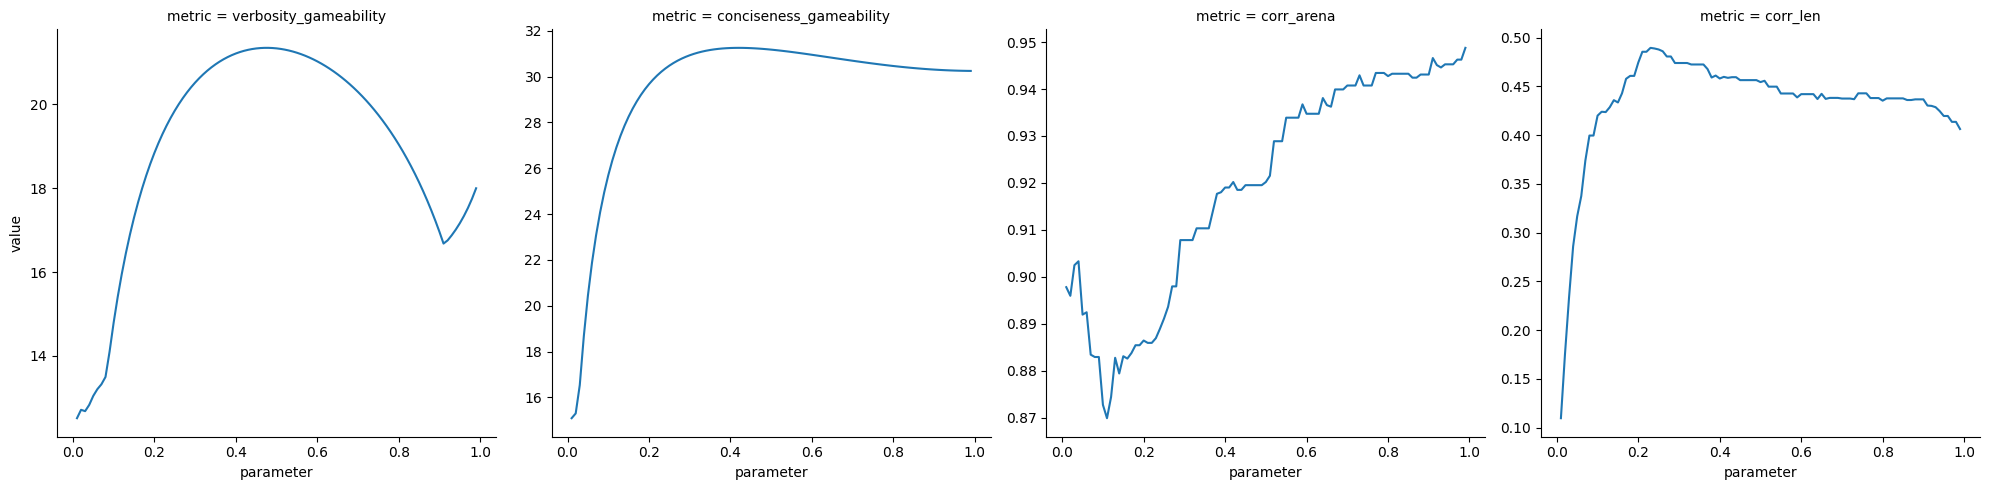

In [17]:
lb_longer["sumpref_1longer"] = lb_longer["mean_1longer"] * lb_longer["count_1longer"]
lb_longer["sumpref_2longer"] = lb_longer["mean_2longer"] * lb_longer["count_2longer"]

def get_weighted_win_rate(lb_longer, weight):
    return (weight *lb_longer["sumpref_1longer"] + (1-weight) * lb_longer["sumpref_2longer"]) / ((weight * lb_longer["count_1longer"] + (1-weight) * lb_longer["count_2longer"])) * 100

weights = np.linspace(0,1,100,endpoint=False)[1:]
plot_metrics_vs_param(get_weighted_win_rate, weights, metric_name="weighted_win_rate")

In [18]:
weight=0.8 
lb_longer["weighted_win_rate"] =get_weighted_win_rate(lb_longer, weight)
report(lb_longer, "weighted_win_rate", is_detailed=False)

# Report for **weighted_win_rate**

## Gameability (lower is better)
Verbosity gameability (relative std metric): 19.0%
Conciseness gameability (relative std metric): 30.5%

## Correlation with Arena (higher is better)
Spearman Corr: 0.943
Kendall Corr: 0.819

## Correlation with length (closer to spearman=0.23, kendall=0.16 is better)
Spearman Corr: 0.435
Kendall Corr: 0.294

## Top 10 models


gpt4_1106_preview_verbose                56.250094
gpt4_1106_preview                             50.0
Snorkel-Mistral-PairRM-DPO-best-of-16     29.68055
pairrm-Yi-34B-Chat                       26.418985
Snorkel-Mistral-PairRM-DPO               26.087726
Yi-34B-Chat                              24.068617
Qwen1.5-72B-Chat                         23.187668
gpt4                                     21.833347
gpt4_1106_preview_concise                21.741323
gpt4_0314                                20.595724
Name: weighted_win_rate, dtype: object


## Bottom 10 models


alpaca-7b_verbose       2.183581
minichat-3b             2.138179
phi-2                   2.104867
chatglm2-6b             2.049623
alpaca-7b               2.044369
guanaco-7b              1.855243
falcon-7b-instruct      1.734801
oasst-sft-pythia-12b    1.634766
baichuan-13b-chat        1.62491
alpaca-7b_concise       1.548759
Name: weighted_win_rate, dtype: object

## Unormalized weighted win-rate

- **What**: similar to the previous metric but you don't rescale the win rate to be between $[0,100]$
- **Benefits**:
    - much better in all metrics than raw win-rate
- **Downside**:
    - scale of win-rate is not $[0,100]$ and will not be given by the fraction of examples that are longer / shorter than the baseline.
    - harder to understand
    - still high correlation with length
 
Note that here w=0.5 recovers the standard win-rate.

/Users/yanndubois/opt/anaconda3/envs/alpaca_eval/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yanndubois/opt/anaconda3/envs/alpaca_eval/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yanndubois/opt/anaconda3/envs/alpaca_eval/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/yanndubois/opt/anaconda3/envs/alpaca_eval/lib/python3.11/site-packages/seaborn/_oldcore.py

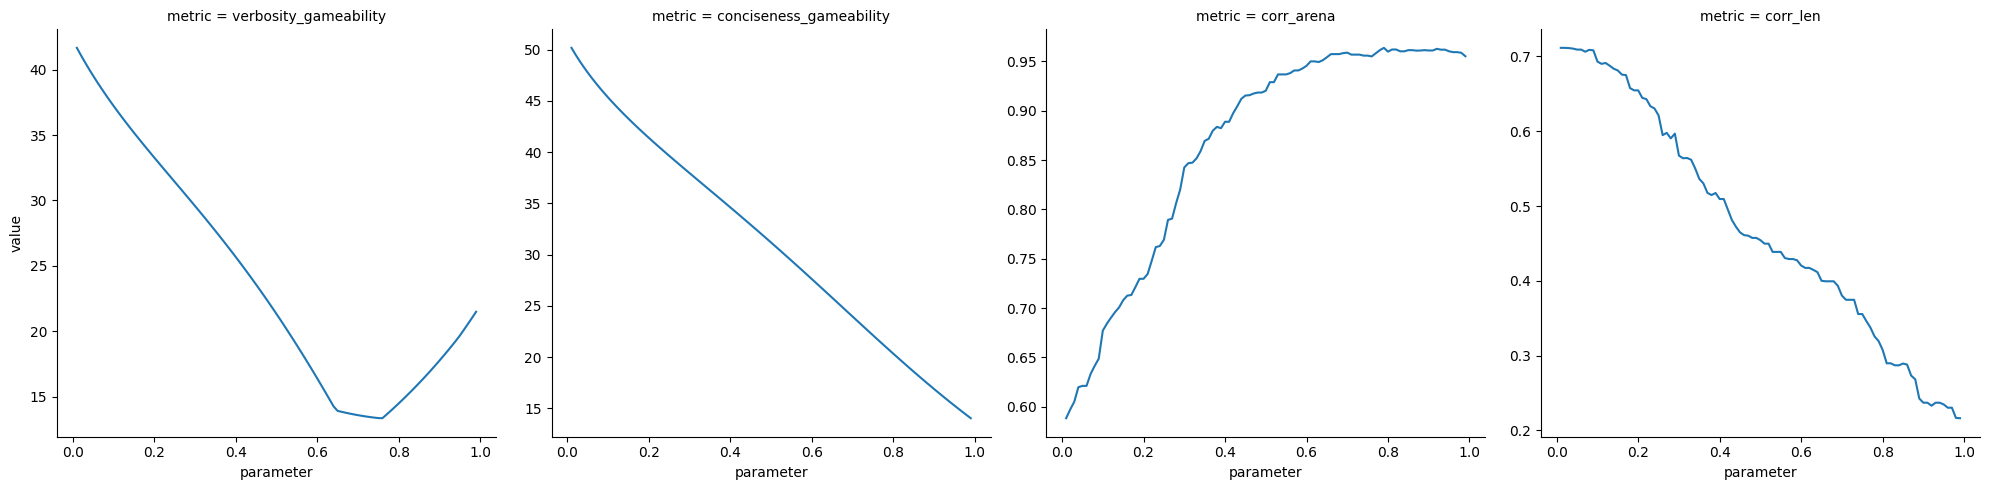

In [19]:

def get_unormalized_weighted_win_rate(lb_longer, weight):
    return (weight *lb_longer["sumpref_1longer"] + (1-weight) * lb_longer["sumpref_2longer"]) / (0.5 *  ( lb_longer["count_1longer"] +  lb_longer["count_2longer"])) * 100

weights = np.linspace(0,1,100,endpoint=False)[1:]
plot_metrics_vs_param(get_unormalized_weighted_win_rate, weights, metric_name="unormalized_weighted_win_rate")

Sweet spot seems to be parameter=0.6-0.7. 

In [20]:
weight=0.65
lb_longer["unormalized_weighted_win_rate"] =get_unormalized_weighted_win_rate(lb_longer, weight)
report(lb_longer, "unormalized_weighted_win_rate", is_detailed=False) 

# Report for **unormalized_weighted_win_rate**

## Gameability (lower is better)
Verbosity gameability (relative std metric): 13.9%
Conciseness gameability (relative std metric): 25.8%

## Correlation with Arena (higher is better)
Spearman Corr: 0.954
Kendall Corr: 0.845

## Correlation with length (closer to spearman=0.23, kendall=0.16 is better)
Spearman Corr: 0.400
Kendall Corr: 0.264

## Top 10 models


gpt4_1106_preview                             50.0
gpt4_1106_preview_verbose                49.585237
Qwen1.5-72B-Chat                         29.701083
Snorkel-Mistral-PairRM-DPO-best-of-16    28.474666
gpt4_1106_preview_concise                28.350624
gpt4                                     28.242867
pairrm-Yi-34B-Chat                       27.426159
gpt4_0314                                26.429635
gpt4_0613_verbose                        26.093454
Yi-34B-Chat                              25.900598
Name: unormalized_weighted_win_rate, dtype: object


## Bottom 10 models


guanaco-13b             3.053912
minichat-3b             3.022104
alpaca-7b               2.866468
chatglm2-6b             2.721326
phi-2                   2.712172
guanaco-7b              2.656111
falcon-7b-instruct      2.366093
oasst-sft-pythia-12b    2.102119
alpaca-7b_concise       2.095599
baichuan-13b-chat       2.045448
Name: unormalized_weighted_win_rate, dtype: object

We see that the correlation with arena is very strong but gameability and length correlation is still relatively high. Furthermore, the intuition is strange as it says that we should give more reward to the cases where the baseline is longer!

## Per-sample length corrected win-rate

- **What**: Same as above but the normalization is done per output rather than on the overall metric. I.e. it's better when you win with a shorter output than the baseline one.
- **Benefits**:
    - simple
    - control for length
- **Downside**:
    - different (harder) interpretation: the range is not between 0-100 anymore and depends on the length of outputs.

In [21]:
all_df_annotations["len_corr_pref"] = all_df_annotations["preference"]  * 100 * all_df_annotations["len_1"] / all_df_annotations["len_2"]
lb["length_corrected_win_rate"] = all_df_annotations.query("len_2 != 0").groupby("model")["len_corr_pref"].mean()[lb.index]
report(lb, "length_corrected_win_rate", is_detailed=False)

# Report for **length_corrected_win_rate**

## Gameability (lower is better)
Verbosity gameability (relative std metric): 4.6%
Conciseness gameability (relative std metric): 14.8%

## Correlation with Arena (higher is better)
Spearman Corr: 0.849
Kendall Corr: 0.678

## Correlation with length (closer to spearman=0.23, kendall=0.16 is better)
Spearman Corr: 0.055
Kendall Corr: 0.044

## Top 10 models


gpt35_turbo_instruct         59.756845
gemini-pro                   59.475346
gpt4_1106_preview_verbose    51.902697
claude-2.1_concise           50.346007
gpt4_1106_preview            50.000000
gpt4                         44.840184
gpt4_1106_preview_concise    43.442884
gpt4_0314                    42.490215
airoboros-65b                35.595773
Qwen1.5-72B-Chat             35.541890
Name: length_corrected_win_rate, dtype: float64


## Bottom 10 models


recycled-wizardlm-7b-v1.0       6.013193
llama-2-chat-7b-evol70k-neft    5.929734
oasst-sft-pythia-12b            5.522854
baize-v2-7b                     5.507437
openbuddy-falcon-7b-v6          5.034488
llama-2-7b-chat-hf              5.015983
chatglm2-6b                     4.872784
guanaco-7b                      4.572563
falcon-7b-instruct              4.532023
guanaco-13b                     4.243997
Name: length_corrected_win_rate, dtype: float64

We see that gameability didn't change much but the correlation with Arena is much worse. Let's not do that. Note that the fact that this is not working well makes me pretty worried about the average length correction.

We see that the values are actually slightly better but that doesn't seem to be worth the added complexity.